# Clasificación de Imágenes con Modelo Preentrenado (MobileNetV2)
Este notebook guía el proceso de clasificación de imágenes de frutas y vegetales utilizando un modelo preentrenado MobileNetV2, que ya ha sido entrenado previamente con el conjunto de datos ImageNet. A continuación se presentan los pasos realizados para preparar los datos, crear el modelo y entrenarlo.

# Importación de Librerías, definicion de datos y carga de archivos
En este primer paso, importamos las librerías necesarias para manejar los datos, preprocesar las imágenes y construir el modelo de clasificación, luego definimos las rutas de los directorios donde se almacenan las imágenes de frutas y vegetales para los conjuntos de datos de entrenamiento, validación y prueba. Luego, listamos las rutas de todos los archivos de imagen en cada conjunto, para luego Crear una función que extrae las etiquetas (nombres de las carpetas) y las rutas de las imágenes, y las organiza en un DataFrame. Las etiquetas de las imágenes se derivan de los nombres de las carpetas donde se almacenan las imágenes (por ejemplo, una carpeta llamada "manzana" tendrá imágenes de manzanas).

In [2]:
import matplotlib.pyplot as plt
# Cambiar el fondo de las figuras a blanco
plt.rcParams['figure.facecolor'] = 'white'

In [6]:
import numpy as np
import pandas as pd
from pathlib import Path
import os.path
import matplotlib.pyplot as plt
import tensorflow as tf

# Definir los directorios donde se encuentran los datos de entrenamiento, prueba y validación
train_dir = Path(r'C:\Users\Mech\Downloads\fruit-and-vegetable-classification\train')  # Cambia la ruta si es necesario
test_dir = Path(r'C:\Users\Mech\Downloads\fruit-and-vegetable-classification\test')  # Cambia la ruta si es necesario
val_dir = Path(r'C:\Users\Mech\Downloads\fruit-and-vegetable-classification\validation')  # Cambia la ruta si es necesario

# Crear listas con las rutas de los archivos de imágenes para entrenamiento, prueba y validación
train_filepaths = list(train_dir.glob(r'**/*.jpg'))
test_filepaths = list(test_dir.glob(r'**/*.jpg'))
val_filepaths = list(val_dir.glob(r'**/*.jpg'))

def proc_img(filepath):
    """Crear un DataFrame con las rutas de los archivos y las etiquetas de las imágenes."""
    
    # Extraer las etiquetas de las imágenes a partir de la estructura de carpetas
    # El nombre de la penúltima carpeta es la etiqueta
    labels = [str(filepath[i]).split(os.path.sep)[-2] for i in range(len(filepath))]

    # Crear las series de pandas para las rutas de los archivos y las etiquetas
    filepath_series = pd.Series(filepath, name='Filepath').astype(str)
    labels_series = pd.Series(labels, name='Label')

    # Concatenar las rutas de los archivos y las etiquetas en un DataFrame
    df = pd.concat([filepath_series, labels_series], axis=1)

    # Barajar aleatoriamente las filas del DataFrame y reiniciar los índices
    df = df.sample(frac=1).reset_index(drop=True)
    
    return df

# Procesar las imágenes para los conjuntos de datos de entrenamiento, prueba y validación
train_df = proc_img(train_filepaths)
test_df = proc_img(test_filepaths)
val_df = proc_img(val_filepaths)

# Mostrar las primeras filas de los DataFrames para verificar
print("DataFrame de entrenamiento:")
print(train_df.head())
print("DataFrame de prueba:")
print(test_df.head())
print("DataFrame de validación:")
print(val_df.head())
print("Hola mundo")


ModuleNotFoundError: No module named 'pandas'

In [31]:
# Imprimir información sobre el conjunto de entrenamiento
print('-- Conjunto de entrenamiento --\n')

# Imprimir el número de imágenes en el conjunto de entrenamiento
print(f'Número de imágenes: {train_df.shape[0]}\n')

# Imprimir el número de etiquetas diferentes en el conjunto de entrenamiento
print(f'Número de etiquetas diferentes: {len(train_df.Label.unique())}\n')

# Imprimir las etiquetas únicas en el conjunto de entrenamiento
print(f'Etiquetas: {train_df.Label.unique()}')


-- Conjunto de entrenamiento --

Número de imágenes: 2855

Número de etiquetas diferentes: 36

Etiquetas: ['sweetcorn' 'pineapple' 'jalepeno' 'eggplant' 'peas' 'apple' 'onion'
 'potato' 'carrot' 'sweetpotato' 'tomato' 'kiwi' 'mango' 'pear' 'lemon'
 'cucumber' 'bell pepper' 'turnip' 'soy beans' 'raddish' 'capsicum'
 'garlic' 'banana' 'grapes' 'watermelon' 'spinach' 'cabbage' 'corn'
 'beetroot' 'chilli pepper' 'pomegranate' 'cauliflower' 'ginger' 'lettuce'
 'paprika' 'orange']


In [32]:
train_df.head(5) #  muestra las primeras 5 filas del DataFrame, que incluirán los valores de las columnas que se hayan  definido

Filepath      Label
0  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...  sweetcorn
1  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...  pineapple
2  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...   jalepeno
3  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...   eggplant
4  C:\Users\Mech\Downloads\fruit-and-vegetable-cl...       peas

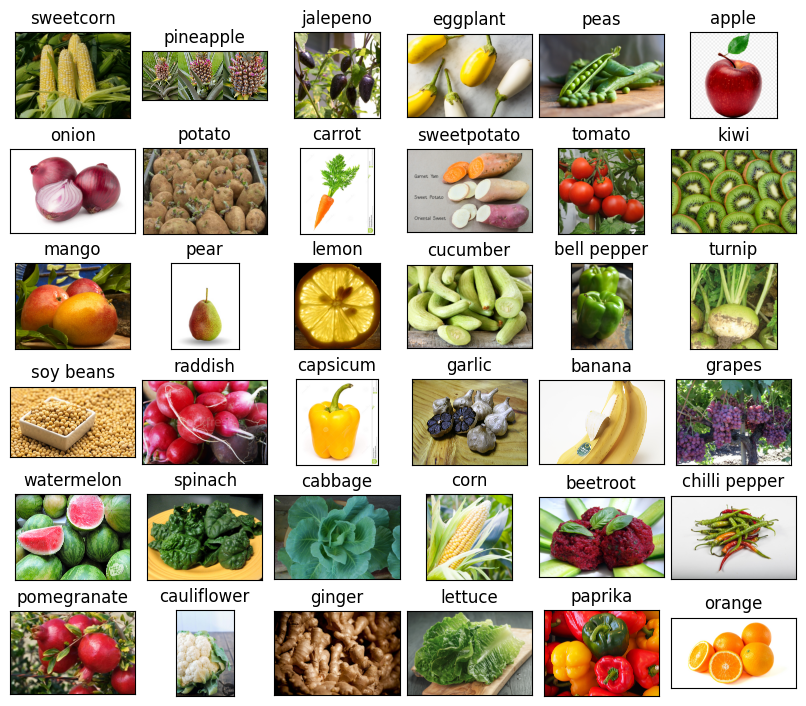

In [33]:
# Crear una copia del DataFrame de entrenamiento y eliminar duplicados basados en la etiqueta
df_unique = train_df.copy().drop_duplicates(subset=["Label"]).reset_index()

# Mostrar algunas imágenes del conjunto de datos
# Configurar la cuadrícula de subgráficas (6 filas y 6 columnas) y ajustar el tamaño de la figura
fig, axes = plt.subplots(nrows=6, ncols=6, figsize=(8, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

# Recorrer cada subgráfico y mostrar una imagen con su etiqueta correspondiente
for i, ax in enumerate(axes.flat):
    # Leer y mostrar la imagen de la ruta especificada en el DataFrame
    ax.imshow(plt.imread(df_unique.Filepath[i]))
    # Establecer el título del subgráfico con la etiqueta (nombre de la clase)
    ax.set_title(df_unique.Label[i], fontsize = 12)

# Ajustar la disposición de las imágenes para que no se solapen
plt.tight_layout(pad=0.5)
# Mostrar el gráfico
plt.show()


 # Preprocesamiento de las Imágenes
 
Usamos ImageDataGenerator de Keras para preprocesar las imágenes. Este generador de datos permite realizar augmentaciones y transformaciones a las imágenes durante el entrenamiento, como rotaciones y desplazamientos , para luego crear los generadores de datos que permiten cargar imágenes en lotes desde los directorios de entrenamiento, validación y prueba. Aquí, también podemos aplicar transformaciones y augmentaciones a las imágenes.

In [34]:
# Crear un generador de imágenes para el conjunto de entrenamiento
train_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # Función de preprocesamiento para las imágenes, en este caso, la que es específica de MobileNetV2
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Crear un generador de imágenes para el conjunto de pruebas
test_generator = tf.keras.preprocessing.image.ImageDataGenerator(
    # Igual que para el conjunto de entrenamiento
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input
)

# Crear el generador para cargar las imágenes de entrenamiento desde el DataFrame
train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,  # Usamos el DataFrame de entrenamiento
    x_col='Filepath',  # La columna que contiene las rutas de los archivos de imagen
    y_col='Label',  # La columna que contiene las etiquetas de las imágenes
    target_size=(224, 224),  # Cambiar el tamaño de las imágenes a 224x224 píxeles
    color_mode='rgb',  # Usar imágenes en formato RGB
    class_mode='categorical',  # Es un problema de clasificación categórica (más de dos clases)
    batch_size=32,  # Usar un tamaño de lote de 32 imágenes por iteración
    shuffle=True,  # Revolver las imágenes aleatoriamente
    seed=0,  # Establecer una semilla para la aleatoriedad (reproducibilidad)
    rotation_range=30,  # Rango de rotación aleatoria de las imágenes (grados)
    zoom_range=0.15,  # Rango de zoom aleatorio en las imágenes
    width_shift_range=0.2,  # Desplazamiento aleatorio horizontal de las imágenes
    height_shift_range=0.2,  # Desplazamiento aleatorio vertical de las imágenes
    shear_range=0.15,  # Rango de deformación (shearing) aleatoria
    horizontal_flip=True,  # Realizar un volteo horizontal aleatorio
    fill_mode="nearest"  # Método para rellenar los píxeles vacíos después de una transformación
)

# Crear el generador para cargar las imágenes de validación desde el DataFrame
val_images = train_generator.flow_from_dataframe(
    dataframe=val_df,  # Usamos el DataFrame de validación
    x_col='Filepath',  # La columna que contiene las rutas de los archivos de imagen
    y_col='Label',  # La columna que contiene las etiquetas de las imágenes
    target_size=(224, 224),  # Cambiar el tamaño de las imágenes a 224x224 píxeles
    color_mode='rgb',  # Usar imágenes en formato RGB
    class_mode='categorical',  # Es un problema de clasificación categórica
    batch_size=32,  # Usar un tamaño de lote de 32 imágenes por iteración
    shuffle=True,  # Revolver las imágenes aleatoriamente
    seed=0,  # Establecer una semilla para la aleatoriedad
    rotation_range=30,  # Rango de rotación aleatoria de las imágenes
    zoom_range=0.15,  # Rango de zoom aleatorio en las imágenes
    width_shift_range=0.2,  # Desplazamiento aleatorio horizontal de las imágenes
    height_shift_range=0.2,  # Desplazamiento aleatorio vertical de las imágenes
    shear_range=0.15,  # Rango de deformación (shearing) aleatoria
    horizontal_flip=True,  # Realizar un volteo horizontal aleatorio
    fill_mode="nearest"  # Método para rellenar los píxeles vacíos después de una transformación
)

# Crear el generador para cargar las imágenes de prueba desde el DataFrame
test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,  # Usamos el DataFrame de pruebas
    x_col='Filepath',  # La columna que contiene las rutas de los archivos de imagen
    y_col='Label',  # La columna que contiene las etiquetas de las imágenes
    target_size=(224, 224),  # Cambiar el tamaño de las imágenes a 224x224 píxeles
    color_mode='rgb',  # Usar imágenes en formato RGB
    class_mode='categorical',  # Es un problema de clasificación categórica
    batch_size=32,  # Usar un tamaño de lote de 32 imágenes por iteración
    shuffle=False  # No revolver las imágenes en el conjunto de prueba (mantener el orden original)
)


Found 2855 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.
Found 340 validated image filenames belonging to 36 classes.


# Cargar modelo Preentrenado (MobilNetV2)
Usamos el modelo MobileNetV2 preentrenado en ImageNet para aprovechar las características que ya ha aprendido. Desactivamos el entrenamiento de las capas preexistentes.

In [35]:
# Cargar el modelo preentrenado MobileNetV2
pretrained_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),  # Forma de entrada de las imágenes, 224x224 píxeles y 3 canales (RGB)
    include_top=False,  # No incluir la capa superior (capa de clasificación final) del modelo original
    weights='imagenet',  # Cargar los pesos preentrenados en ImageNet
    pooling='avg'  # Aplicar una capa de agrupamiento global (promedio) al final del modelo para reducir las dimensiones
)

# Establecer las capas del modelo preentrenado como no entrenables
pretrained_model.trainable = False


# Construir el Modelo
Añadimos nuestras propias capas de salida (densas y de activación softmax) para la clasificación de frutas y vegetales en base a las características extraídas por MobileNetV2.
### ¿Por qué usar un modelo preentrenado?

El uso de un modelo preentrenado es una técnica común en el aprendizaje profundo, especialmente cuando trabajamos con tareas de clasificación de imágenes. Un **modelo preentrenado** es un modelo de red neuronal que ha sido previamente entrenado en un gran conjunto de datos, como **ImageNet**. Este modelo ya ha aprendido representaciones generales de las imágenes (por ejemplo, detectar bordes, texturas, formas, etc.) que pueden ser útiles para una gran variedad de problemas.

Usar un modelo preentrenado tiene varias ventajas:

1. **Aceleración del entrenamiento**: Entrenar un modelo desde cero puede ser muy costoso en términos de tiempo y recursos computacionales. Un modelo preentrenado ya tiene conocimientos generales sobre la estructura de las imágenes, lo que hace que el proceso de entrenamiento sea más rápido y eficiente.

2. **Mejor rendimiento con menos datos**: Un modelo que ha sido entrenado en un gran conjunto de datos como ImageNet puede generalizar mejor en tareas similares, incluso con un conjunto de datos más pequeño. Esto se debe a que el modelo ya ha aprendido características de bajo nivel que son comunes en muchas imágenes.

3. **Transferencia de aprendizaje**: Este enfoque se basa en la idea de que las representaciones aprendidas en una tarea pueden ser reutilizadas en otra tarea relacionada. Al usar un modelo preentrenado, podemos realizar un **ajuste fino** (fine-tuning) para adaptarlo a nuestro conjunto de datos específico. Esto implica modificar solo algunas capas del modelo o entrenar solo las capas finales mientras dejamos congeladas las primeras capas, que contienen características generales de las imágenes.

4. **Menor riesgo de sobreajuste**: Como el modelo preentrenado ya ha aprendido características generales de las imágenes, tiene una mejor capacidad para generalizar a nuevas imágenes, lo que reduce el riesgo de sobreajuste, especialmente cuando se tiene un conjunto de datos pequeño.

En resumen, los modelos preentrenados permiten que los investigadores y desarrolladores aprovechen el aprendizaje acumulado de grandes conjuntos de datos, optimizando recursos y mejorando el rendimiento del modelo en tareas específicas.


In [36]:
# Obtener las entradas del modelo preentrenado MobileNetV2
inputs = pretrained_model.input
# numero de columnas del dataset 
# Añadir una capa densa (fully connected) con 128 unidades y activación ReLU
x = tf.keras.layers.Dense(128, activation='relu')(pretrained_model.output)

# Añadir otra capa densa con 128 unidades y activación ReLU
x = tf.keras.layers.Dense(128, activation='relu')(x)

# Capa de salida con 36 unidades (una para cada clase) y activación softmax para clasificación multiclase
outputs = tf.keras.layers.Dense(36, activation='softmax')(x)

# Crear el modelo con las entradas y salidas definidas
model = tf.keras.Model(inputs=inputs, outputs=outputs)

# Compilar el modelo con optimizador Adam, pérdida categórica y métricas de precisión
model.compile(
    optimizer='adam',  # Optimización utilizando Adam, que es un optimizador eficiente para este tipo de redes neuronales
    loss='categorical_crossentropy',  # Función de pérdida para clasificación multiclase
    metrics=['accuracy']  # Métrica de evaluación: precisión
)

# Entrenar el modelo utilizando los generadores de imágenes de entrenamiento y validación
history = model.fit(
    train_images,  # Datos de entrenamiento
    validation_data=val_images,  # Datos de validación
    batch_size=32,  # Tamaño de lote (número de imágenes procesadas por cada iteración)
    epochs=5,  # Número de épocas (cuántas veces el modelo pasará por todo el conjunto de datos)
    callbacks=[  # Usar callbacks para mejorar el proceso de entrenamiento
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',  # Monitorizar la pérdida de validación
            patience=2,  # Si no mejora después de 2 épocas, detiene el entrenamiento
            restore_best_weights=True  # Restaurar los mejores pesos (el que obtuvo la menor pérdida)
        )
    ]
)


Epoch 1/5
90/90 [==============================] - 51s 553ms/step - loss: 1.7713 - accuracy: 0.5306 - val_loss: 0.4651 - val_accuracy: 0.8706
Epoch 2/5
90/90 [==============================] - 66s 737ms/step - loss: 0.5843 - accuracy: 0.8133 - val_loss: 0.2706 - val_accuracy: 0.9265
Epoch 3/5
90/90 [==============================] - 67s 739ms/step - loss: 0.3540 - accuracy: 0.8886 - val_loss: 0.2329 - val_accuracy: 0.9294
Epoch 4/5
90/90 [==============================] - 52s 575ms/step - loss: 0.2188 - accuracy: 0.9324 - val_loss: 0.1802 - val_accuracy: 0.9382
Epoch 5/5
90/90 [==============================] - 64s 712ms/step - loss: 0.1758 - accuracy: 0.9443 - val_loss: 0.1632 - val_accuracy: 0.9618


# Predicciones y Metricas

Finalmente, realizamos predicciones sobre el conjunto de prueba y calculamos métricas adicionales como la matriz de confusión para ver el desempeño del modelo en cada clase, Después de entrenar el modelo, es útil observar las gráficas de accuracy y loss tanto para los conjuntos de entrenamiento como de validación. Esto nos ayudará a entender si el modelo está aprendiendo correctamente y si se está sobreajustando.

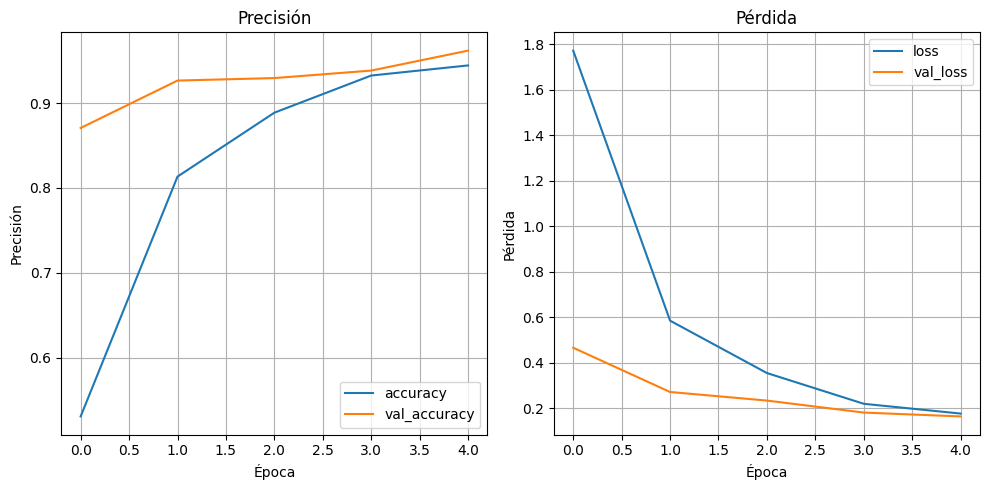

In [50]:
# Crear un gráfico con la precisión durante el entrenamiento y la validación
history_data = pd.DataFrame(history.history)

# Crear una figura con dos subgráficas en una fila
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))  # 1 fila, 2 columnas

# Gráfico de precisión en el primer eje
history_data[['accuracy', 'val_accuracy']].plot(ax=ax1)
ax1.set_title("Precisión")
ax1.set_xlabel("Época")
ax1.set_ylabel("Precisión")
ax1.set_facecolor('white')
ax1.grid(True)

# Gráfico de pérdida en el segundo eje
history_data[['loss', 'val_loss']].plot(ax=ax2)
ax2.set_facecolor('white')
ax2.set_title("Pérdida")
ax2.set_xlabel("Época")
ax2.set_ylabel("Pérdida")
ax2.grid(True)

# Ajustar el espaciado para que no se solapen los gráficos
plt.style.use('default')
plt.tight_layout()
plt.show()



In [39]:
# Predecir la etiqueta de las imágenes de prueba
pred = model.predict(test_images)

# Obtener la etiqueta con la probabilidad más alta
pred = np.argmax(pred, axis=1)

# Mapeo de etiquetas (de índices a nombres de clase)
labels = (train_images.class_indices)
labels = dict((v, k) for k, v in labels.items())

# Convertir las predicciones de índices a nombres de las clases
pred = [labels[k] for k in pred]

# Convertir las etiquetas verdaderas de las imágenes de prueba de índices a nombres de las clases
y_test = [labels[k] for k in test_images.classes]


11/11 [==============================] - 10s 841ms/step


In [40]:
labels.items()


dict_items([(0, 'apple'), (1, 'banana'), (2, 'beetroot'), (3, 'bell pepper'), (4, 'cabbage'), (5, 'capsicum'), (6, 'carrot'), (7, 'cauliflower'), (8, 'chilli pepper'), (9, 'corn'), (10, 'cucumber'), (11, 'eggplant'), (12, 'garlic'), (13, 'ginger'), (14, 'grapes'), (15, 'jalepeno'), (16, 'kiwi'), (17, 'lemon'), (18, 'lettuce'), (19, 'mango'), (20, 'onion'), (21, 'orange'), (22, 'paprika'), (23, 'pear'), (24, 'peas'), (25, 'pineapple'), (26, 'pomegranate'), (27, 'potato'), (28, 'raddish'), (29, 'soy beans'), (30, 'spinach'), (31, 'sweetcorn'), (32, 'sweetpotato'), (33, 'tomato'), (34, 'turnip'), (35, 'watermelon')])

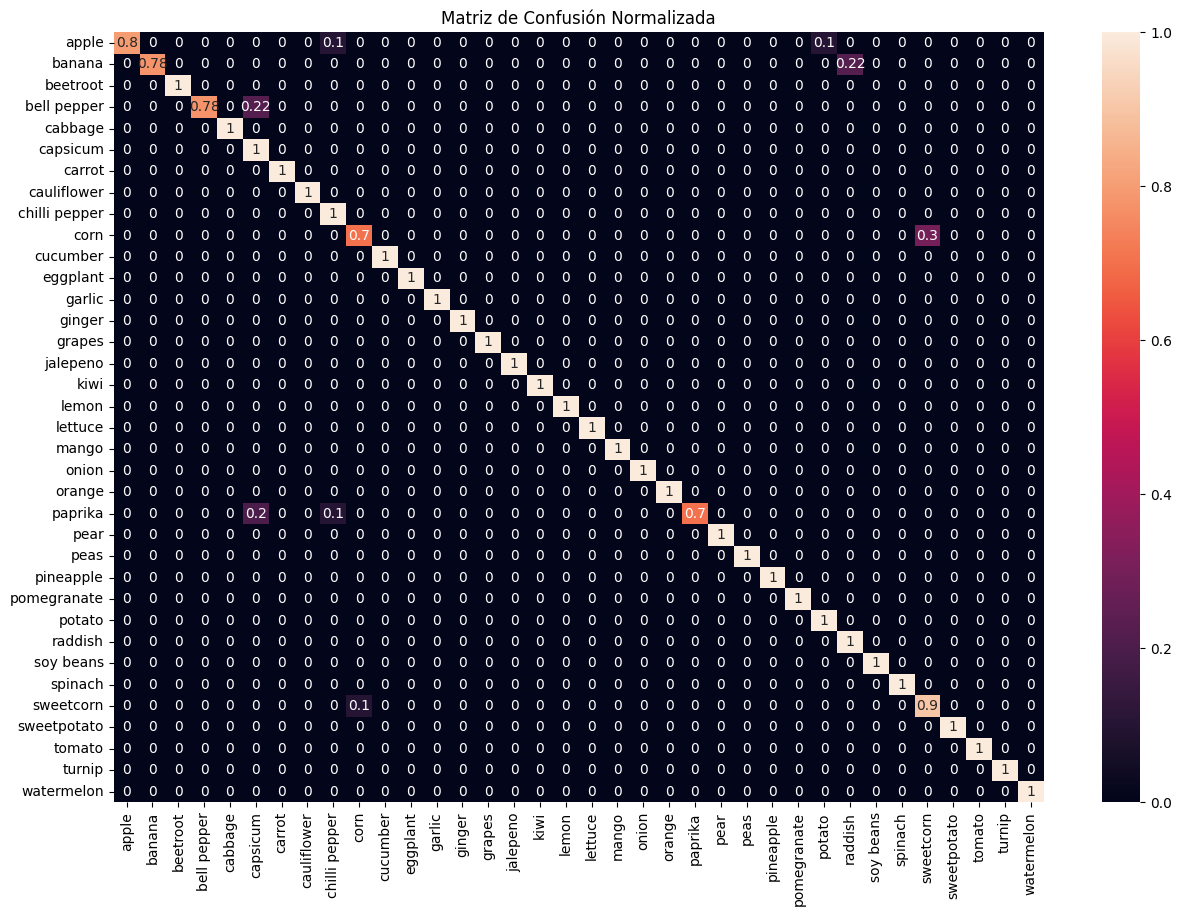

Reporte de clasificación:
               precision    recall  f1-score   support

        apple       1.00      0.80      0.89        10
       banana       1.00      0.78      0.88         9
     beetroot       1.00      1.00      1.00        10
  bell pepper       1.00      0.78      0.88         9
      cabbage       1.00      1.00      1.00        10
     capsicum       0.71      1.00      0.83        10
       carrot       1.00      1.00      1.00         8
  cauliflower       1.00      1.00      1.00        10
chilli pepper       0.78      1.00      0.88         7
         corn       0.88      0.70      0.78        10
     cucumber       1.00      1.00      1.00        10
     eggplant       1.00      1.00      1.00        10
       garlic       1.00      1.00      1.00        10
       ginger       1.00      1.00      1.00        10
       grapes       1.00      1.00      1.00         9
     jalepeno       1.00      1.00      1.00         9
         kiwi       1.00      1.00    

In [41]:
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Calcular la matriz de confusión normalizada
cf_matrix = confusion_matrix(y_test, pred, normalize='true')

# Configurar el tamaño de la figura para el gráfico
plt.figure(figsize=(15,10))

# Crear un mapa de calor de la matriz de confusión
sns.heatmap(cf_matrix, 
            annot=True,  # Mostrar los valores en cada celda
            xticklabels=sorted(set(y_test)),  # Etiquetas de las clases predichas
            yticklabels=sorted(set(y_test))   # Etiquetas de las clases reales
            )

# Título del gráfico
plt.title('Matriz de Confusión Normalizada')

# Mostrar el gráfico
plt.show()

report = classification_report(y_test, pred)
print("Reporte de clasificación:")
print(report)


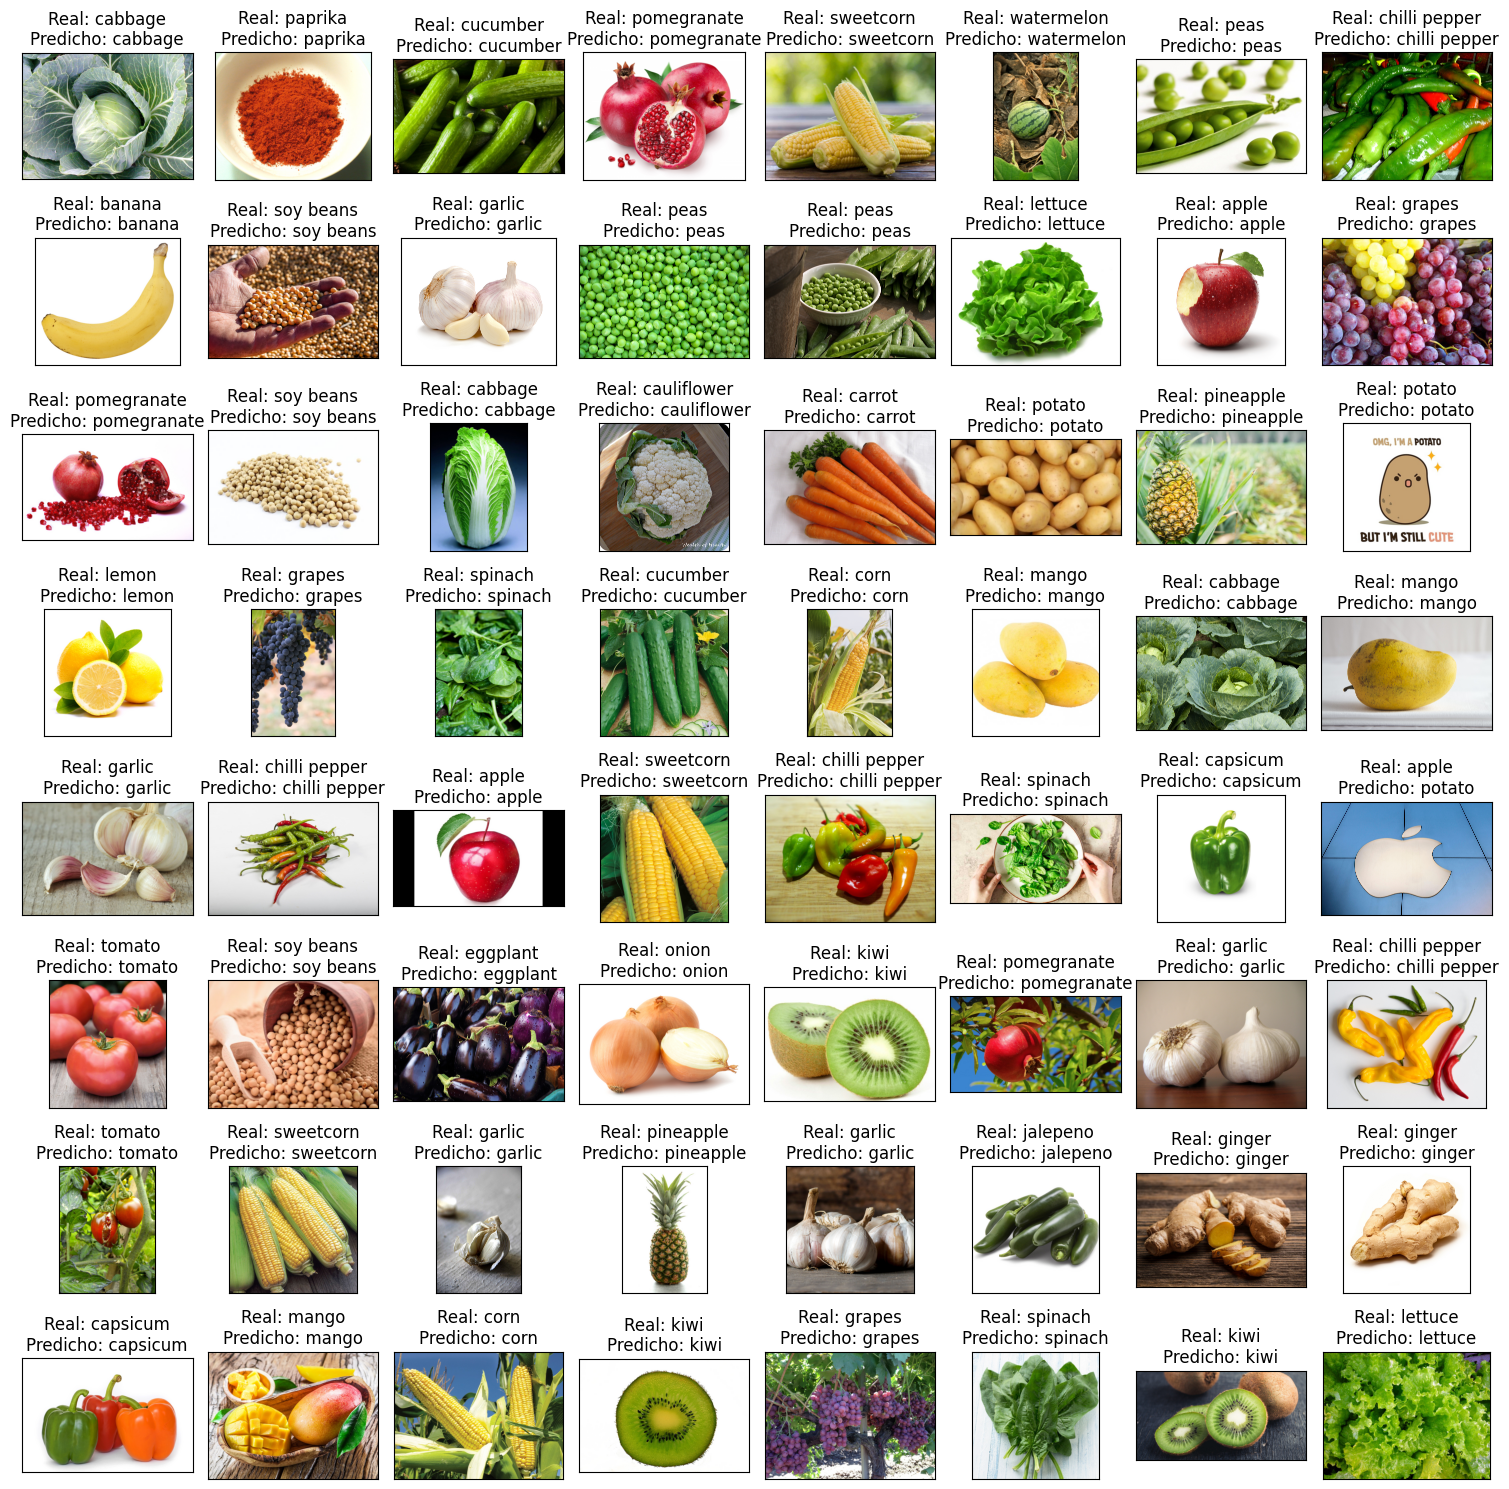

In [42]:
# Mostrar algunas imágenes del conjunto de prueba con sus etiquetas y las predicciones
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(15, 15),  # Crear una figura con 3 filas y 3 columnas de subgráficos
                        subplot_kw={'xticks': [], 'yticks': []})  # Eliminar las marcas de los ejes X y Y

# Iterar sobre los subgráficos y mostrar las imágenes junto con sus etiquetas reales y predicciones
for i, ax in enumerate(axes.flat):
    ax.imshow(plt.imread(test_df.Filepath.iloc[i]))  # Leer y mostrar la imagen desde el DataFrame de prueba
    ax.set_title(f"Real: {test_df.Label.iloc[i]}\nPredicho: {pred[i]}")  # Mostrar la etiqueta real y la predicción

# Ajustar el espaciado entre los subgráficos
plt.tight_layout()

# Mostrar el gráfico final
plt.style.use('default')
plt.show()


In [52]:
import matplotlib.cm as cm

def get_img_array(img_path, size):
    img = tf.keras.preprocessing.image.load_img(img_path, target_size=size)
    array = tf.keras.preprocessing.image.img_to_array(img)
    # We add a dimension to transform our array into a "batch"
    # of size "size"
    array = np.expand_dims(array, axis=0)
    return array

def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

def save_and_display_gradcam(img_path, heatmap, cam_path="cam.jpg", alpha=0.4):
    # Load the original image
    img = tf.keras.preprocessing.image.load_img(img_path)
    img = tf.keras.preprocessing.image.img_to_array(img)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)

    # Save the superimposed image
    superimposed_img.save(cam_path)

    # Display Grad CAM
#     display(Image(cam_path))
    
    return cam_path
    
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions

last_conv_layer_name = "Conv_1"
img_size = (224,224)

# Remove last layer's softmax
model.layers[-1].ativation = None

C:\Users\Mech\AppData\Local\Temp\ipykernel_28308\2064122198.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  jet = cm.get_cmap("jet")


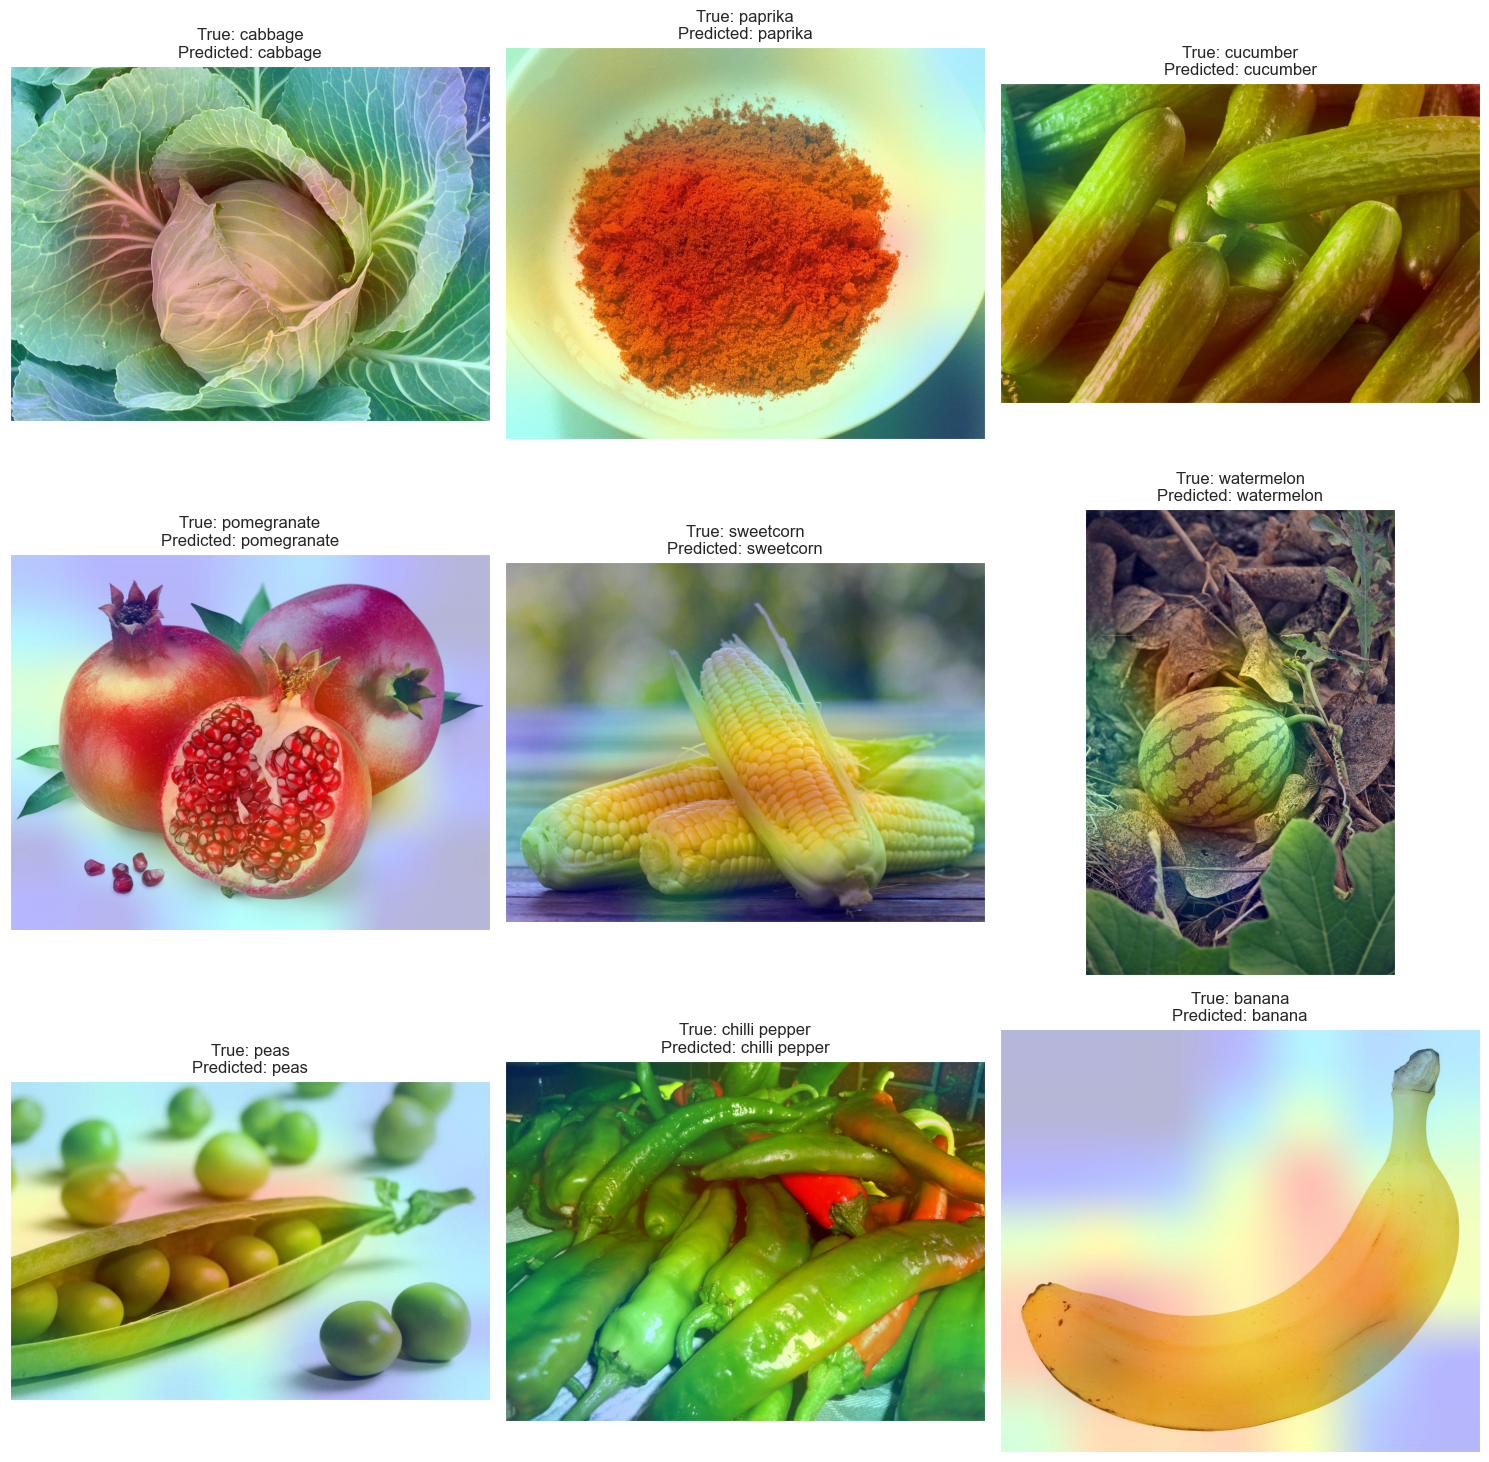

In [53]:
# Display the part of the pictures used by the neural network to classify the pictures
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    img_path = test_df.Filepath.iloc[i]
    img_array = preprocess_input(get_img_array(img_path, size=img_size))
    heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
    cam_path = save_and_display_gradcam(img_path, heatmap)
    ax.imshow(plt.imread(cam_path))
    ax.set_title(f"True: {test_df.Label.iloc[i]}\nPredicted: {pred[i]}")
plt.tight_layout()
plt.show()

In [55]:
def output(location):
    from tensorflow.keras.preprocessing.image import load_img,img_to_array
    img=load_img(location,target_size=(224,224,3))
    img=img_to_array(img)
    img=img/255
    img=np.expand_dims(img,[0])
    answer=model.predict(img)
    y_class = answer.argmax(axis=-1)
    y = " ".join(str(x) for x in y_class)
    y = int(y)
    res = labels[y]
    return res

In [61]:
from IPython.display import display
from PIL import Image

location = 'C:/Users/Mech/Downloads'
display(Image.open(location))

PermissionError: [Errno 13] Permission denied: 'C:\\Users\\Mech\\Downloads'